In [ ]:
from gladedb.classes import Base, Galaxy, GalaxySim
from gladedb import catalogs
from gladedb.simulate import fake_catalogs as fc
from gladedb.simulate import fake_skymaps as fs
from gladedb.helpers import find_galaxies_in_skymap

import sqlalchemy as sa

#### Create a database to query GLADE+ and UpGLADE catalogs

In [ ]:
# on terminal command line after installing postgresql@15
# createdb gwcosmo_db

#### Connect the database and create the tables

In [ ]:
engine = sa.create_engine('postgresql://localhost/gwcosmo_db', echo=False)
Base.metadata.create_all(engine)

#### Read in GLADE+ and insert into database

In [ ]:
# Warning: This will take a long time to run
catalogs.create_gladeplus_catalog()

#### Read in GLADE+, convert to radians for more narrow but dense simulated UpGLADE catalog and insert into database

In [ ]:
# Warning: This will take a long time to run
fc.create_fake_catalogs()

#### Create a generic Gaussian MOC skymap to insert into the database

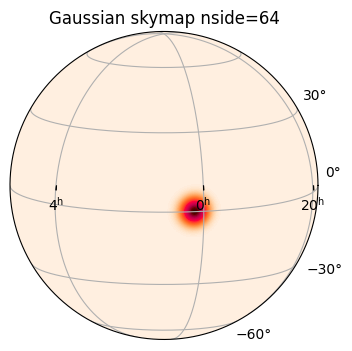

In [ ]:
from gladedb.simulate.fake_skymaps import generate_gaussian_skymap
import matplotlib.pyplot as plt
import ligo.skymap.plot

# Define the min and max ra/dec values of the simulated galaxy catalog 
# to calculate center of simulated skymap
with sa.orm.Session(engine) as session:
    result = session.query(
        sa.func.min(GalaxySim.ra), sa.func.max(GalaxySim.ra),
        sa.func.min(GalaxySim.dec), sa.func.max(GalaxySim.dec)
    ).one()

min_ra, max_ra, min_dec, max_dec = result
center_ra = (min_ra + max_ra) / 2
center_dec = (min_dec + max_dec) / 2

nside = 64
skymap = generate_gaussian_skymap(nside, center_ra, center_dec, sigma=3, degrees=True)

plt.figure(figsize=(8, 4))
ax = plt.axes(projection='astro globe', center='1h 10d')
ax.grid()
ax.imshow_hpx(skymap, cmap='cylon', nested=True)
ax.set_title(f"Gaussian skymap nside={nside}")
plt.show()

In [ ]:
fs.create_gaussian_skymap(center_ra, center_dec, sigma=3, nside=1024, db_id=1)
fs.create_gaussian_skymap(center_ra, center_dec, sigma=3, nside=64, db_id=2)

#### Query to find the number of galaxies that are present in a given skymap

In [ ]:
# Gaussian nside = 1024 skymap with normal GLADE+ catalog
galaxies = find_galaxies_in_skymap(skymap_id=1, engine=engine)

Query run time: 446.115 seconds, Number of galaxies: 2217645 over 820907 healpix indexes


In [ ]:
# Gaussian nside = 1024 skymap with normal GLADE+ catalog
galaxies = find_galaxies_in_skymap(skymap_id=1, engine=engine, contour_level=0.1)

Query run time: 158.812 seconds, Number of galaxies: 5659 over 1471 healpix indexes


In [ ]:
# Gaussian nside = 64 skymap with normal GLADE+ catalog
galaxies = find_galaxies_in_skymap(skymap_id=2, engine=engine)
# Gaussian nside = 64 skymap with normal GLADE+ catalog
galaxies = find_galaxies_in_skymap(skymap_id=2, engine=engine, contour_level=0.1)

Query run time: 164.807 seconds, Number of galaxies: 4874299 over 10108 healpix indexes
Query run time: 118.577 seconds, Number of galaxies: 4981 over 6 healpix indexes


In [ ]:
# Gaussian nside = 64 skymap with fake UpGLADE catalog
galaxies = find_galaxies_in_skymap(skymap_id=2, engine=engine, GalaxyClass=GalaxySim)

Query run time: 507.328 seconds, Number of galaxies: 21882694 over 35 healpix indexes


#### Query to find the number of galaxies that are present at a given coordinate (healpix index) with resolution of nside

In [ ]:
from gladedb.helpers import find_galaxies_in_range

nside_values = [16, 64, 256, 1024, 2048, 4096]

# For the normal GLADE+ catalog
for nside in nside_values:
    find_galaxies_in_range(center_ra, center_dec, engine, Galaxy, nside)

Query run time: 12.214 seconds, Number of galaxies: 11064, nside: 16
Query run time: 8.366 seconds, Number of galaxies: 822, nside: 64
Query run time: 8.11 seconds, Number of galaxies: 33, nside: 256
Query run time: 7.33 seconds, Number of galaxies: 1, nside: 1024
Query run time: 6.932 seconds, Number of galaxies: 0, nside: 2048
Query run time: 9.516 seconds, Number of galaxies: 0, nside: 4096


In [ ]:
# For the simulated UpGLADE catalog
for nside in nside_values:
    find_galaxies_in_range(center_ra, center_dec, engine, GalaxySim, nside)

Query run time: 32.875 seconds, Number of galaxies: 14325561, nside: 16
Query run time: 13.405 seconds, Number of galaxies: 1952031, nside: 64
Query run time: 9.214 seconds, Number of galaxies: 125821, nside: 256
Query run time: 7.7 seconds, Number of galaxies: 10691, nside: 1024
Query run time: 7.145 seconds, Number of galaxies: 3439, nside: 2048
Query run time: 6.882 seconds, Number of galaxies: 827, nside: 4096
